![ups logo](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png/640px-Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png)

# Inteligencia Artificial

# Practica 03

# Transformaciones, KNN vs Redes Neuronales

### Autor: Diego Tapia


## Descripción del dataset

Nombre del dataset: Statlog (German Credit Data). Enlace: http://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data) [1]

Descripción general: Este conjunto de datos clasifica a las personas descritas por un conjunto de atributos como riesgos crediticios buenos o malos.

Número de Variables (o atributos): 21

Número de instancias (clientes en el banco): 1000

**Salida**:

TIPOCLIENTE (BUENO:1, MALO:2)

### Importacion de librerias

In [1]:
# Importacion de librerias

%pip install scikeras

import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt 

from time import time
from datetime import datetime, timedelta

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import load_model

from sklearn import metrics 
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn import set_config   

print("Módulos y clases importados")

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


Módulos y clases importados


### Carga del dataset



In [3]:
nombresVariables=['ESTADOCUENTACORRIENTE','PLAZOMESESCREDITO','HISTORIALCREDITO','PROPOSITOCREDITO','MONTOCREDITO',
                  'SALDOCUENTAAHORROS','TIEMPOACTUALEMPLEO','TASAPAGO','ESTADOCIVILYSEXO','GARANTE','TIEMPORESIDENCIAACTUAL',
                  'ACTIVOS','EDAD','OTROSPLANESPAGO','VIVIENDA','CANTIDADCREDITOSEXISTENTES','EMPLEO',
                  'CANTIDADPERSONASAMANTENER','TELEFONO','TRABAJADOREXTRANJERO','TIPOCLIENTE']
#Para cargar un dataframe desde una URL
dfOriginal = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data', sep = ' ', 
                         names=nombresVariables)

dataframe=copy.deepcopy(dfOriginal)
print('cantidad de observaciones (clientes): ',dataframe.shape[0])
print('cantidad de variables: ',dataframe.shape[1])
print(dataframe.shape)
dataframe.head()

cantidad de observaciones (clientes):  1000
cantidad de variables:  21
(1000, 21)


,ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,...,ACTIVOS,EDAD,OTROSPLANESPAGO,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TELEFONO,TRABAJADOREXTRANJERO,TIPOCLIENTE
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


## 1. Descripción de variables del dataset

|Id	|Variable	|Descripción breve	|Tipo	|Técnica de transformación a aplicar|
----|------------|-------------------|------------|------------------------------|
|1	|ESTADOCUENTACORRIENTE	|Indica si existe o no una cuenta corriente|Categórica ordinal|Codificación binaria|
|2	|PLAZOMESESCREDITO |Duracion del prestamo en meses|	Numérica discreta	|Estandarización|
|3	|HISTORIALCREDITO |Historial de credito; sin credito, retraso en pagos, creditos pagados|Categórica ordinal (en el contexto del banco)|	Codificación binaria|
|4  |PROPOSITOCREDITO |Proposito del credito: auto nuevo, educacion, reparaciones, negocios, etc.|Categórica nominal| Codificación binaria|
|5  |MONTOCREDITO |Cantidad del credito|Numérica continua| Estandarización|
|6  |SALDOCUENTAAHORROS |Ahorros en la cuenta o límites; < 100 USD, 100 USD <X < 500 USD, 1000 USD >,desconocido |Categórica ordinal| Codificación binaria|
|7  |TIEMPOACTUALEMPLEO |Indica el tiempo  que trabaja el cliente o el estado; desempleado, < 1 año, 1año<X<4años, > 7años |Categórica ordinal| Codificación binaria|
|8  |TASAPAGO |Tasa de pago a plazos en porcentaje del ingreso disponible |Numérica continua| Estandarización|
|9  |ESTADOCIVILYSEXO |Indica el estado civil y sexo; hombre:divorciado, mujer:soltera: hombre:casado, ... |Categórica ordinal (en el contexto del banco)| Codificación binaria|
|10 |GARANTE |Indica si tiene codeudores o garantes; ninguno, codeudor, garante |Categórica nominal|Codificación binaria|
|11 |TIEMPORESIDENCIAACTUAL |Tiempo de residencia en años |Numérica discreta| Estandarización|
|12 |ACTIVOS |activos o bienes del cliente; desconocidos, autos ,sin propiedad,bienes raices, etc. |Categórica ordinal (en el contexto del banco)| Codificación binaria|
|13 |EDAD |Edad del cliente en años |Numérica discreta| Estandarización|
|14 |OTROSPLANESPAGO |Otros planes de pago del cliente; banco, tiendas, ninguno |Categórica nominal| Se elimina la variable, no se considera relevante para este análisis|
|15 |VIVIENDA |Tipo de vivienda; rentada, propia, cedida |Categórica ordinal (en el contexto del banco)| Codificación binaria|
|16 |CANTIDADCREDITOSEXISTENTES |Número de préstamos exisentes en el banco |Numérica discreta| Estandarización|
|17 |EMPLEO  |Indica el estado de empleo del cliente; desempleado, trabajador no calificado,trabajador calificado, administrativo, autonomo, etc.  |Categórica ordinal (en el contexto del banco)| Codificación binaria|
|18 |CANTIDADPERSONASAMANTENER |Número de personas de la que es responsable el cliente.  |Numérica discreta| Estandarización|
|19 |TELEFONO |Indica si se tiene o no registrado el numero del cliente; SI, NO  |Categórica nominal| Se elimina la variable, no se considera relevante para este análisis|
|20 |TRABAJADOREXTRANJERO |Indica si es trabajador extranjero o no; SI, NO  |Categórica nominal| Codificación binaria|
|21 |**TIPOCLIENTE** |**Variable objetivo.** Indica si es un cliente Bueno o Malo para el credito; 1: Bueno, 0: Malo  |Numérica discreta| Codificación binaria|



## 2. Modelo K Nearest Neighbor (KNN) 

### Preparación de los datos

#### Formato a la variable de salida

Se modifica la variable de salida (de estudio): TIPOCLIENTE. Es mejor tener la salida en formato binario cuando hay dos clases


In [12]:
dfOriginal['TIPOCLIENTE'] = dfOriginal['TIPOCLIENTE'].replace(2, 0)
dfOriginal.head()

,ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,...,ACTIVOS,EDAD,OTROSPLANESPAGO,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TELEFONO,TRABAJADOREXTRANJERO,TIPOCLIENTE
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


#### Eliminación de variables y separación de variable de salida

Se separa la variable de salida "Y" para poder realizar la preparación de datos a las variables independiente "X" 

In [13]:
dataframe=copy.deepcopy(dfOriginal)
print(dataframe.shape)
Y=dataframe['TIPOCLIENTE']
dataframe=dataframe.drop(['OTROSPLANESPAGO'], axis=1)
dataframe=dataframe.drop(['TELEFONO'], axis=1)
dataframe=dataframe.drop(['TIPOCLIENTE'], axis=1)
print(dataframe.shape)
dataframe.head()

(1000, 21)
(1000, 18)


,ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,TIEMPORESIDENCIAACTUAL,ACTIVOS,EDAD,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TRABAJADOREXTRANJERO
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A152,2,A173,1,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A152,1,A173,1,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A152,1,A172,2,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A153,1,A173,2,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A153,2,A173,2,A201


### 2.1 KNN sin transformación de variables y sin balanceo

#### Diseño

En esta sección se evalúa el método KNN con distintos valores de parámetros. El código itera a través de diferentes distancias (por ejemplo, euclidiana, manhattan, chebyshev y una personalizada) y diferentes valores de K (10, 20, 30, etc.) para evaluar el rendimiento del modelo. Se calculan varias métricas de rendimiento, como: Error Absoluto Medio (MAE), Error Cuadrático Medio (MSE), Raíz del Error Cuadrático Medio (RMSE), Accuracy (ACC), Precision, Recall (Sensibilidad) y F1-Score. Estas métricas miden el rendimiento del modelo en la clasificación de datos. Se ejecuta N experimentos por cada valor de K. Luego, se calcula el promedio de los N experimentos.

Se eliminan las variables categoricas del dataset

In [39]:
dataframe_datos_numericos = dataframe.select_dtypes(include='number')
dataframe_datos_numericos.head()

,PLAZOMESESCREDITO,MONTOCREDITO,TASAPAGO,TIEMPORESIDENCIAACTUAL,EDAD,CANTIDADCREDITOSEXISTENTES,CANTIDADPERSONASAMANTENER
0,6,1169,4,4,67,2,1
1,48,5951,2,2,22,1,1
2,12,2096,2,3,49,1,2
3,42,7882,2,4,45,1,2
4,24,4870,3,4,53,2,2


In [40]:
# Función para transformar la predicción         
def transformarPrediccion(lista):
    for i in range(len(lista)):
        desempenio=lista[i]
        #print(desempenio)
        if (desempenio < 0.5):
            desempenio = 0
        elif (desempenio >= 0.5):
            desempenio = 1
        lista[i]=desempenio
    return lista

In [41]:
# función de distancia personalizada
def distancia_personalizada(x, y):
    # Por ejemplo, aquí utilizamos la distancia Euclidiana con un peso especial
    return ((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2) * 0.5

#### Agrupar resultados por medida de distancia y cantidad de vecinos (K)
Se agrupa los resultados por medida de distancia y cantidad de vecinos. Se puede apreciar los resultados de N experimentos por cada valor de K.

In [42]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier #KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV



In [46]:
# Crear un DataFrame vacío con las columnas deseadas
columnas = ['DISTANCE', 'K', 'ACC', 'PRECISION', 'RECALL', 'F1-SCORE']

# Definir el tipo de dato de cada columna
tipos_de_variable = [str, int, float, float, float, float]

model = None

# Definir las distancias a calcular
DISTANCE = ['euclidean', 'manhattan', 'chebyshev', 'propia']

# Definir los valores de K (la cantidad de vecinos que conforman el vecindario)
K = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
valoresK = K

# Definir la cantidad de experimentos que se repiten por cada valor de K. Luego, se calculará el promedio de K experimentos
def realizar_experimentos(dataframe_datos_numericos, Y, nExperimentos):

    # Crear un DataFrame vacío, a este dataframe se agregarán fila a fila los resultados de KNN
    dataResultados = pd.DataFrame(columns=columnas)

    for idexp in range(nExperimentos):
        # Crear las particiones del conjunto de datos. De manera convencional, el conjunto de test contiene el 20% de los datos.
        X_train, X_test, y_train, y_test = train_test_split(dataframe_datos_numericos, Y, test_size=0.2)
        for d in DISTANCE:
            for k in K:
                # Llamar a la función personalizada
                if d == 'propia':
                    model = KNeighborsClassifier(n_neighbors=k, metric=distancia_personalizada)
                else:
                    model = KNeighborsClassifier(n_neighbors=k, metric=d)
                # Entrenar el modelo
                history = model.fit(X_train, y_train)
                # Calcular predicciones para el conjunto de Test
                y_pred = model.predict(X_test)
                y_pred = y_pred.flatten()
                # Transformar salida continua a discreta (binaria)
                y_pred = transformarPrediccion(y_pred)
                # Evaluar el modelo con medidas de calidad
                MAE = metrics.mean_absolute_error(y_test, y_pred)
                MSE = metrics.mean_squared_error(y_test, y_pred)
                RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
                y_testBinario = (y_test >= 0.5).astype("int32")
                y_predBinario = (y_pred >= 0.5).astype("int32")
                ACC = float(str(accuracy_score(y_testBinario, y_predBinario)))
                precision = precision_score(y_testBinario, y_predBinario)
                recall = recall_score(y_testBinario, y_predBinario)
                f1 = f1_score(y_testBinario, y_predBinario)
                MAE = float(str(round(MAE, 4)))
                MSE = float(str(round(MSE, 4)))
                RMSE = float(str(round(RMSE, 4)))
                precision = float(str(round(precision, 4)))
                recall = float(str(round(recall, 4)))
                f1 = float(str(round(f1, 4)))
                valor = [d, k, ACC, precision, recall, f1]
                # print(valor)
                fila = pd.Series(valor, index=columnas)
                # Agregar los resultados en el dataframe
                dataResultados = pd.concat([dataResultados, fila.to_frame().T], ignore_index=True)

    # Convertir el tipo de datos de cada columna
    dataResultados['K'] = dataResultados['K'].astype(int)
    dataResultados['ACC'] = dataResultados['ACC'].astype(float)
    dataResultados['PRECISION'] = dataResultados['PRECISION'].astype(float)
    dataResultados['RECALL'] = dataResultados['RECALL'].astype(float)
    dataResultados['F1-SCORE'] = dataResultados['F1-SCORE'].astype(float)
    dataResultados = dataResultados.sort_values(by=['DISTANCE', 'K'])
    dataResultados = dataResultados.reset_index(drop=True)

    return dataResultados


Resultados con 5 experimentos

In [60]:
resultados_5_exp = realizar_experimentos(dataframe_datos_numericos, Y, 5)
resultados_5_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.680,0.7289,0.8643,0.7908
1,chebyshev,10,0.715,0.7572,0.8973,0.8213
2,chebyshev,10,0.660,0.7485,0.8188,0.7821
3,chebyshev,10,0.610,0.6647,0.8519,0.7468
4,chebyshev,10,0.660,0.7451,0.7972,0.7703


Resultados con 10 experimentos

In [48]:
resultados_10_exp = realizar_experimentos(dataframe_datos_numericos, Y, 10)
resultados_10_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.680,0.7069,0.9044,0.7935
1,chebyshev,10,0.635,0.6829,0.8421,0.7542
2,chebyshev,10,0.600,0.6707,0.8088,0.7333
3,chebyshev,10,0.645,0.7099,0.8273,0.7641
4,chebyshev,10,0.650,0.6798,0.9030,0.7756


Resultados con 20 experimentos

In [49]:
resultados_20_exp = realizar_experimentos(dataframe_datos_numericos, Y, 20)
resultados_20_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.615,0.6628,0.8571,0.7475
1,chebyshev,10,0.615,0.6788,0.8235,0.7442
2,chebyshev,10,0.660,0.7070,0.8346,0.7655
3,chebyshev,10,0.675,0.7469,0.8345,0.7883
4,chebyshev,10,0.685,0.7143,0.9058,0.7987


Resultados con 30 experimentos

In [50]:
resultados_30_exp = realizar_experimentos(dataframe_datos_numericos, Y, 30)
resultados_30_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.640,0.6726,0.8692,0.7584
1,chebyshev,10,0.630,0.7143,0.8042,0.7566
2,chebyshev,10,0.615,0.6928,0.8156,0.7492
3,chebyshev,10,0.630,0.6726,0.8561,0.7533
4,chebyshev,10,0.670,0.7278,0.8601,0.7885


#### Agrupar resultados por medida de distancia y cantidad de vecinos (K)


Se agrupa los resultados por medida de distancia y cantidad de vecinos. Se puede apreciar los resultados de N experimentos por cada valor de K.

**Agrupación con 5 experimentos**

In [61]:
resultados_5_exp = resultados_5_exp.groupby(['DISTANCE','K'])
resultados_5_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.680,0.7289,0.8643,0.7908
1,chebyshev,10,0.715,0.7572,0.8973,0.8213
2,chebyshev,10,0.660,0.7485,0.8188,0.7821
3,chebyshev,10,0.610,0.6647,0.8519,0.7468
4,chebyshev,10,0.660,0.7451,0.7972,0.7703
...,...,...,...,...,...,...
195,propia,100,0.700,0.7000,1.0000,0.8235
196,propia,100,0.730,0.7300,1.0000,0.8439
197,propia,100,0.745,0.7475,0.9933,0.8530
198,propia,100,0.675,0.6750,1.0000,0.8060


Se calcula el promedio de los 5 experimentos

In [62]:

resultados_5_exp = resultados_5_exp.mean()
resultados_5_exp = resultados_5_exp.reset_index()
resultados_5_exp = resultados_5_exp.reset_index(drop=True)
resultados_5_exp = resultados_5_exp.groupby(['DISTANCE'])
resultados_5_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.665,0.72888,0.84590,0.78226
1,chebyshev,20,0.691,0.72178,0.92316,0.80970
2,chebyshev,30,0.715,0.72656,0.96380,0.82806
3,chebyshev,40,0.715,0.72402,0.97074,0.82902
4,chebyshev,50,0.712,0.71986,0.97624,0.82838
10,euclidean,10,0.676,0.73294,0.85840,0.78998
11,euclidean,20,0.690,0.72040,0.92450,0.80936
12,euclidean,30,0.714,0.72578,0.96380,0.82756
13,euclidean,40,0.715,0.72402,0.97074,0.82902
14,euclidean,50,0.712,0.71986,0.97624,0.82838


**Agrupación con 10 experimentos**



In [65]:
resultados_10_exp = resultados_10_exp.groupby(['DISTANCE','K'])
resultados_10_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.680,0.7069,0.9044,0.7935
1,chebyshev,10,0.635,0.6829,0.8421,0.7542
2,chebyshev,10,0.600,0.6707,0.8088,0.7333
3,chebyshev,10,0.645,0.7099,0.8273,0.7641
4,chebyshev,10,0.650,0.6798,0.9030,0.7756
...,...,...,...,...,...,...
390,propia,100,0.680,0.6800,1.0000,0.8095
391,propia,100,0.665,0.6650,1.0000,0.7988
392,propia,100,0.680,0.6800,1.0000,0.8095
393,propia,100,0.695,0.6950,1.0000,0.8201


Se calcula el promedio de los 10 experimentos

In [66]:
resultados_10_exp = resultados_10_exp.mean()
resultados_10_exp = resultados_10_exp.reset_index()
resultados_10_exp = resultados_10_exp.reset_index(drop=True)
resultados_10_exp = resultados_10_exp.groupby(['DISTANCE'])
resultados_10_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.6515,0.70256,0.85266,0.76994
1,chebyshev,20,0.6735,0.69780,0.92420,0.79483
2,chebyshev,30,0.6850,0.69680,0.95709,0.80607
3,chebyshev,40,0.6870,0.69553,0.96648,0.80861
4,chebyshev,50,0.6950,0.69772,0.97862,0.81451
10,euclidean,10,0.6545,0.70407,0.85585,0.77201
11,euclidean,20,0.6740,0.69813,0.92413,0.79505
12,euclidean,30,0.6850,0.69680,0.95709,0.80607
13,euclidean,40,0.6870,0.69553,0.96648,0.80861
14,euclidean,50,0.6950,0.69772,0.97862,0.81451


**Agrupación con 20 experimentos**

In [67]:
resultados_20_exp = resultados_20_exp.groupby(['DISTANCE','K'])
resultados_20_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.615,0.6628,0.8571,0.7475
1,chebyshev,10,0.615,0.6788,0.8235,0.7442
2,chebyshev,10,0.660,0.7070,0.8346,0.7655
3,chebyshev,10,0.675,0.7469,0.8345,0.7883
4,chebyshev,10,0.685,0.7143,0.9058,0.7987
...,...,...,...,...,...,...
780,propia,100,0.665,0.6650,1.0000,0.7988
781,propia,100,0.680,0.6800,1.0000,0.8095
782,propia,100,0.665,0.6650,1.0000,0.7988
783,propia,100,0.725,0.7250,1.0000,0.8406


Se calcula el promedio de los 20 experimentos

In [68]:
resultados_20_exp = resultados_20_exp.mean()
resultados_20_exp = resultados_20_exp.reset_index()
resultados_20_exp = resultados_20_exp.reset_index(drop=True)
resultados_20_exp = resultados_20_exp.groupby(['DISTANCE'])
resultados_20_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.65075,0.710620,0.839255,0.768460
1,chebyshev,20,0.67725,0.701985,0.928535,0.798925
2,chebyshev,30,0.69650,0.704045,0.969170,0.815145
3,chebyshev,40,0.69775,0.702780,0.976765,0.816930
4,chebyshev,50,0.69425,0.699995,0.977825,0.815415
10,euclidean,10,0.65375,0.711990,0.841885,0.770565
11,euclidean,20,0.67775,0.702390,0.928470,0.799155
12,euclidean,30,0.69675,0.704390,0.968825,0.815230
13,euclidean,40,0.69775,0.702780,0.976765,0.816930
14,euclidean,50,0.69425,0.699910,0.978200,0.815475


**Agrupación con 30 experimentos**

In [69]:
resultados_30_exp = resultados_30_exp.groupby(['DISTANCE','K'])
resultados_30_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.640,0.6726,0.8692,0.7584
1,chebyshev,10,0.630,0.7143,0.8042,0.7566
2,chebyshev,10,0.615,0.6928,0.8156,0.7492
3,chebyshev,10,0.630,0.6726,0.8561,0.7533
4,chebyshev,10,0.670,0.7278,0.8601,0.7885
...,...,...,...,...,...,...
1170,propia,100,0.650,0.6500,1.0000,0.7879
1171,propia,100,0.715,0.7150,1.0000,0.8338
1172,propia,100,0.705,0.7050,1.0000,0.8270
1173,propia,100,0.660,0.6600,1.0000,0.7952


Se calcula el promedio de los 30 experimentos

In [70]:
resultados_30_exp = resultados_30_exp.mean()
resultados_30_exp = resultados_30_exp.reset_index()
resultados_30_exp = resultados_30_exp.reset_index(drop=True)
resultados_30_exp = resultados_30_exp.groupby(['DISTANCE'])
resultados_30_exp.head()

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.659167,0.721257,0.840620,0.775643
1,chebyshev,20,0.687500,0.714057,0.926360,0.805967
2,chebyshev,30,0.705833,0.715037,0.966690,0.821580
3,chebyshev,40,0.708000,0.714277,0.974193,0.823803
4,chebyshev,50,0.708333,0.713227,0.978490,0.824650
10,euclidean,10,0.662167,0.722493,0.843500,0.777757
11,euclidean,20,0.688500,0.714863,0.926337,0.806487
12,euclidean,30,0.706000,0.715087,0.966923,0.821700
13,euclidean,40,0.708000,0.714277,0.974193,0.823803
14,euclidean,50,0.708333,0.713227,0.978490,0.824650


#### Visualización de resultados

Visualización de Resultados  con 5 experimentos

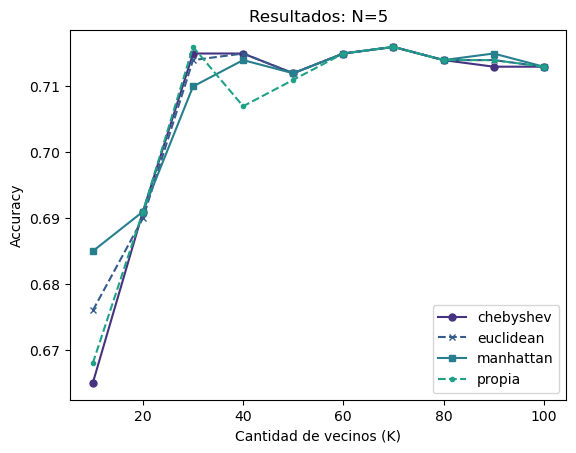

In [64]:

sns.set_palette("viridis")
for name in resultados_5_exp.groups.keys():
    group = resultados_5_exp.get_group(name)
    #print(name)
    valores=group.ACC.values.tolist()
    #print(valores)
    #SIN EFECTO SUAVIZADO
    if name=='euclidean': plt.plot(valoresK, valores, marker='x', linestyle='--', color='C1', ms=5, label = name) 
    if name=='manhattan': plt.plot(valoresK, valores, marker='s', linestyle='-', color='C2', ms=5, label = name)    
    if name=='propia': plt.plot(valoresK, valores, marker='o', linestyle='--', color='C9', ms=3, label = name)
    if name=='chebyshev': plt.plot(valoresK, valores, marker='.', linestyle='-', color='C0', ms=10, label = name)
    plt.title("Resultados: N=5")
    plt.xlabel("Cantidad de vecinos (K)")   # Inserta el título del eje X 
    plt.ylabel("Accuracy")   # Inserta el título del eje Y
    plt.legend(loc="lower right")

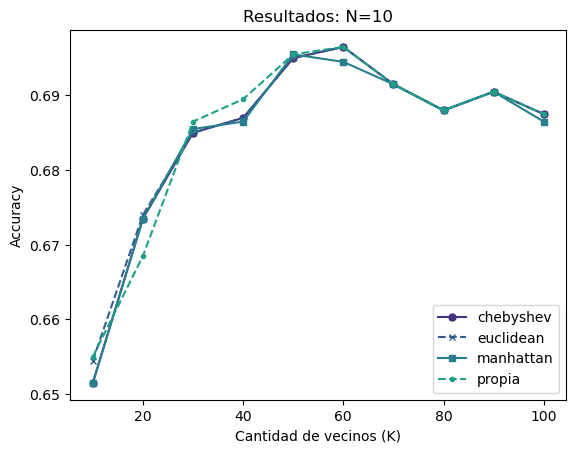

In [71]:
for name in resultados_10_exp.groups.keys():
    group = resultados_10_exp.get_group(name)
    #print(name)
    valores=group.ACC.values.tolist()
    #print(valores)
    #SIN EFECTO SUAVIZADO
    if name=='euclidean': plt.plot(valoresK, valores, marker='x', linestyle='--', color='C1', ms=5, label = name) 
    if name=='manhattan': plt.plot(valoresK, valores, marker='s', linestyle='-', color='C2', ms=5, label = name)    
    if name=='propia': plt.plot(valoresK, valores, marker='o', linestyle='--', color='C9', ms=3, label = name)
    if name=='chebyshev': plt.plot(valoresK, valores, marker='.', linestyle='-', color='C0', ms=10, label = name)
    plt.title("Resultados: N=10")
    plt.xlabel("Cantidad de vecinos (K)")   # Inserta el título del eje X 
    plt.ylabel("Accuracy")   # Inserta el título del eje Y
    plt.legend(loc="lower right")

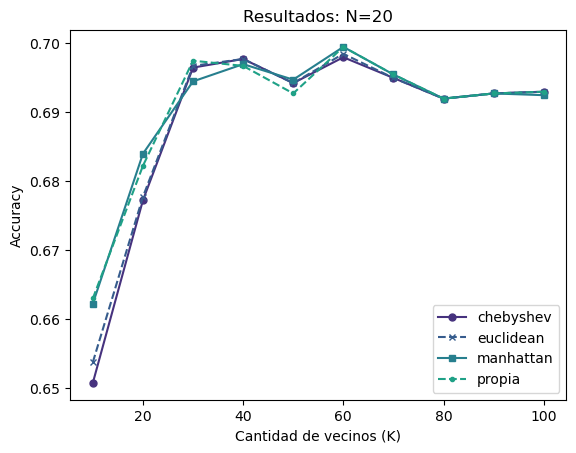

In [72]:
for name in resultados_20_exp.groups.keys():
    group = resultados_20_exp.get_group(name)
    #print(name)
    valores=group.ACC.values.tolist()
    #print(valores)
    #SIN EFECTO SUAVIZADO
    if name=='euclidean': plt.plot(valoresK, valores, marker='x', linestyle='--', color='C1', ms=5, label = name) 
    if name=='manhattan': plt.plot(valoresK, valores, marker='s', linestyle='-', color='C2', ms=5, label = name)    
    if name=='propia': plt.plot(valoresK, valores, marker='o', linestyle='--', color='C9', ms=3, label = name)
    if name=='chebyshev': plt.plot(valoresK, valores, marker='.', linestyle='-', color='C0', ms=10, label = name)
    plt.title("Resultados: N=20")
    plt.xlabel("Cantidad de vecinos (K)")   # Inserta el título del eje X 
    plt.ylabel("Accuracy")   # Inserta el título del eje Y
    plt.legend(loc="lower right")

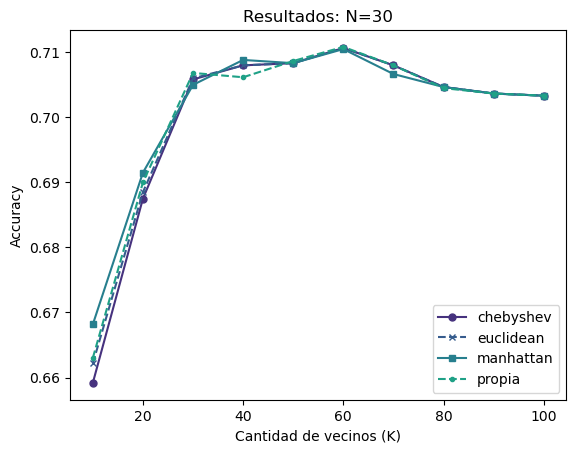

In [74]:
for name in resultados_30_exp.groups.keys():
    group = resultados_30_exp.get_group(name)
    #print(name)
    valores=group.ACC.values.tolist()
    #print(valores)
    #SIN EFECTO SUAVIZADO
    if name=='euclidean': plt.plot(valoresK, valores, marker='x', linestyle='--', color='C1', ms=5, label = name) 
    if name=='manhattan': plt.plot(valoresK, valores, marker='s', linestyle='-', color='C2', ms=5, label = name)    
    if name=='propia': plt.plot(valoresK, valores, marker='o', linestyle='--', color='C9', ms=3, label = name)
    if name=='chebyshev': plt.plot(valoresK, valores, marker='.', linestyle='-', color='C0', ms=10, label = name)
    plt.title("Resultados: N=30")
    plt.xlabel("Cantidad de vecinos (K)")   # Inserta el título del eje X 
    plt.ylabel("Accuracy")   # Inserta el título del eje Y
    plt.legend(loc="lower right")